In [19]:
from PIL import Image
from pathlib import Path
import json
import imagehash
from bitarray import bitarray
import numpy as np
import tqdm
import matplotlib.pyplot as plt

### db

In [20]:
json_path ='../../backend/flask-app/storage/records.json'
with open(json_path) as f:
    db_data = json.load(f)
res = []
for o in db_data:
    chash = bitarray(o['pHash'] + o['dHash'])
    res.append((o['object_id'],
                bitarray(o['aHash']),
                bitarray(o['pHash']),
                bitarray(o['dHash']),
                bitarray(o['wHash']),
                chash))
object_id, ahash, phash, dhash, whash, chash = zip(*res)
db = {
    'object_id': object_id,
    'ahash': ahash,
    'phash': phash,
    'dhash': dhash,
    'whash': whash,
    'chash': chash,
}

### pic

In [21]:
PIC_PATH = Path('../dataset/taken_small')

In [22]:
true_map_path = '../annotation/true_map.csv'
with open(true_map_path) as f:
    true_map_raw = f.read()
true_map = [o.split(',') for o in true_map_raw.split('\n')][:-1]
name, object_id = zip(*true_map)
pic = {
    'name': name,
    'object_id': object_id,
}

In [23]:
crop_path = '../annotation/crop.txt'
with open(crop_path) as f:
    crop_raw = f.read()
crop_lines = crop_raw.split('\n')[:-1]
def split_line(line):
    com = line.index(',')
    name = line[:com]
    crops = line[com+1:]
    l1, l2, l3 = crops.split(',{')
    l1 = json.loads(l1)
    l2 = json.loads('{' + l2)
    l3 = json.loads('{' + l3)
    return name,l1,l2,l3
crops = [split_line(o) for o in crop_lines]

In [24]:
# combine
dic = {name: i for i,name in enumerate(pic['name'])}
l1s = [None] * len(pic['name'])
l2s = [None] * len(pic['name'])
l3s = [None] * len(pic['name'])
for name, l1, l2, l3 in crops:
    i = dic[name]
    l1s[i] = l1;l2s[i] = l2;l3s[i] = l3
pic['l1'] = l1s;pic['l2'] = l2s;pic['l3'] = l3s

# test crop

In [25]:
 # (left, upper, right, lower)-tuple.
def to_box(image, crop):
    width, height = image.size
    x, y, w, h = crop['x']/100, crop['y']/100, crop['width']/100, crop['height']/100
    x1 = int(x * width)
    y1 = int(y * height)
    x2 = int((x + w) * width) - 1
    y2 = int((y + h) * height) - 1
    return (x1, y1, x2, y2)

In [26]:
def get_matched_index(i, hfunc, nfunc, level):
    name = pic['name'][i]
    image_path = PIC_PATH / name
    image = Image.open(image_path)
    crop = pic[level][i]
    target_id = pic['object_id'][i]
    #
    c_image = image.crop(to_box(image, crop))
    c_image.load()
    if nfunc != 'chash':
        raw_hash = ''.join(list(hfunc(c_image).hash.flatten().astype(int).astype(str)))
    else:
        raw_hash = ''
        for hfunc in [imagehash.phash, imagehash.dhash]:
            raw_hash += ''.join(list(hfunc(c_image).hash.flatten().astype(int).astype(str)))
    h = bitarray(raw_hash)
    #
    idx = np.argsort([(h ^ h1).count(1) for h1 in db[nfunc]])
    matched = [db['object_id'][i] for i in idx]
    return matched.index(target_id), matched

In [27]:
hash_opts = [
    (imagehash.average_hash, 'ahash'),
    (imagehash.phash, 'phash'),
    (imagehash.dhash, 'dhash'),
    (imagehash.whash, 'whash'),
    (None, 'chash'),
]
l_opts = ['l1', 'l2', 'l3']
midx_dict = {}
for hfunc, nfunc in hash_opts:
    for l in l_opts:
        print(nfunc, l)
        midx = []; marray = []
        for i in tqdm.tqdm(list(range(len(pic['name'])))):
            mi, ma = get_matched_index(i, hfunc, nfunc, l)
            midx.append(mi)
            marray.append(ma)
        midx = np.array(midx)
        marray = np.array(marray)
        midx_dict[(nfunc, l)] = (midx, marray)

ahash l1


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 33.70it/s]


ahash l2


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 32.19it/s]


ahash l3


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 30.11it/s]


phash l1


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 28.92it/s]


phash l2


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 34.46it/s]


phash l3


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 33.21it/s]


dhash l1


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 35.05it/s]


dhash l2


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:02<00:00, 35.76it/s]


dhash l3


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 35.38it/s]


whash l1


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:04<00:00, 21.85it/s]


whash l2


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:04<00:00, 24.45it/s]


whash l3


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:04<00:00, 25.15it/s]


chash l1


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 33.85it/s]


chash l2


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 32.52it/s]


chash l3


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:03<00:00, 29.23it/s]


6 IMG_20191102_104050.jpg
32500
32987


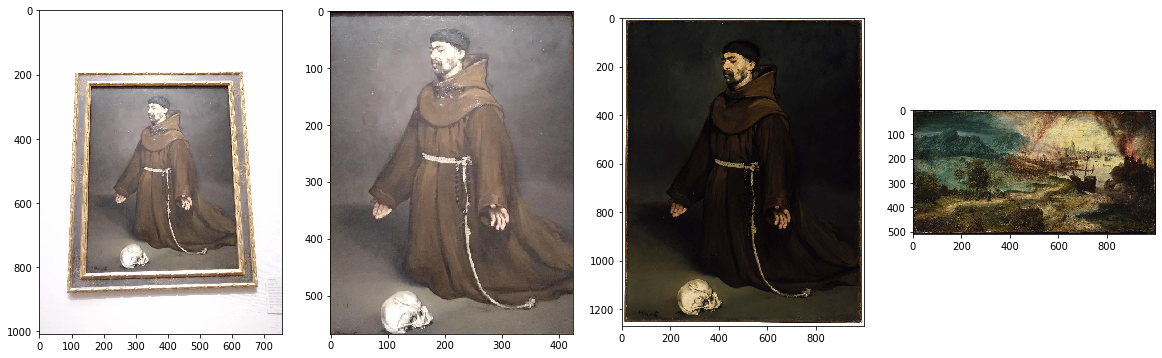

68 IMG_20191102_110425.jpg
30846
26671


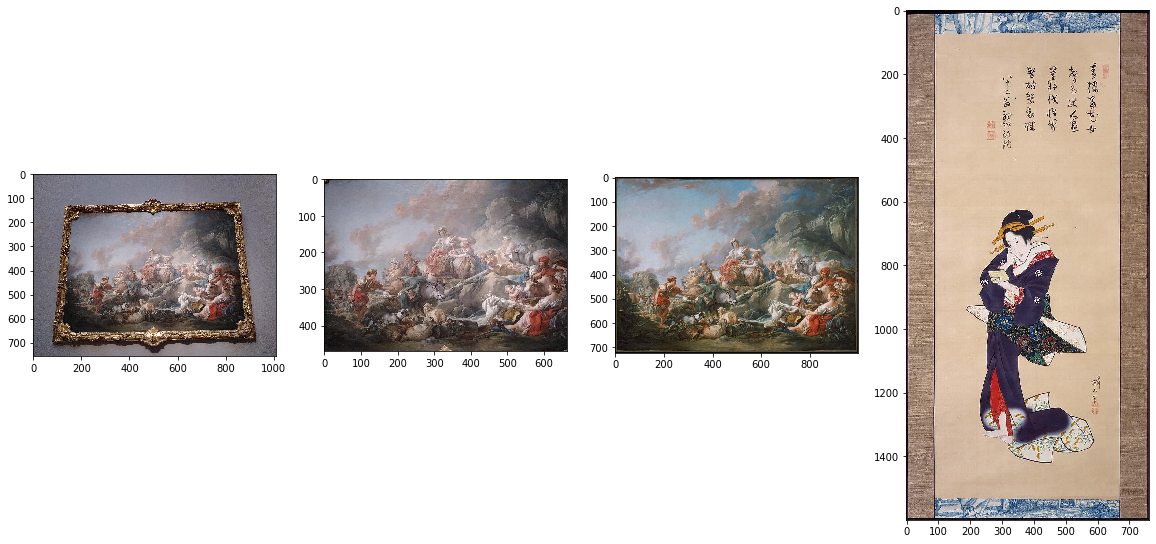

71 IMG_20191102_110533.jpg
30845
34175


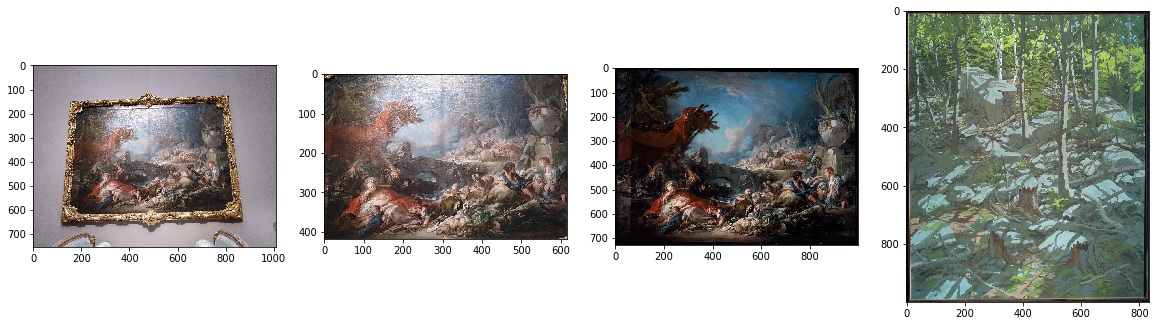

In [38]:
level = 'l3'
(midx, marray) = midx_dict[('chash', level)]
TRUE_PATH = Path('../../backend/flask-app/storage/images')
for i in range(len(midx)):
    if midx[i] != 0:
        fig = plt.figure(figsize=(20, 100))
        name = pic['name'][i]
        print(i, name)
        image_path = PIC_PATH / name
        image = Image.open(image_path)
        plt.subplot(1, 4, 1)
        plt.imshow(np.array(image))
        #
        crop = pic[level][i]
        c_image = image.crop(to_box(image, crop))
        plt.subplot(1, 4, 2)
        plt.imshow(c_image)
        #
        object_id = pic['object_id'][i]
        print(object_id)
        true_path = TRUE_PATH / (object_id + '.jpg')
        image_true = Image.open(true_path)
        plt.subplot(1, 4, 3)
        plt.imshow(np.array(image_true))
        #
        object_id2 = marray[i][0]
        print(object_id2)
        true_path = TRUE_PATH / (object_id2 + '.jpg')
        image_true = Image.open(true_path)
        plt.subplot(1, 4, 4)
        plt.imshow(np.array(image_true))
        plt.show()

In [29]:
midx

array([ 0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [30]:
for hfunc, nfunc in hash_opts:
    for l in l_opts:
        print(nfunc, l)
        midx = midx_dict[(nfunc, l)][0]
        print(np.sum(midx==0), np.sum(midx<5), np.sum(midx<10))

ahash l1
67 81 86
ahash l2
72 82 85
ahash l3
71 82 84
phash l1
97 103 103
phash l2
100 106 106
phash l3
99 106 107
dhash l1
86 95 97
dhash l2
95 98 99
dhash l3
92 99 99
whash l1
56 71 76
whash l2
67 75 81
whash l3
64 75 77
chash l1
104 105 106
chash l2
104 106 106
chash l3
104 106 106


## vis

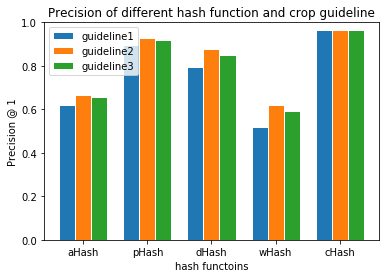

In [31]:
def plot(K=1):
    barWidth = 0.25
    bars1 = []
    bars2 = []
    bars3 = []
    for hfunc, nfunc in hash_opts:
        midx1 = midx_dict[(nfunc, 'l1')][0]
        bars1.append(np.sum(midx1 < K)/108)
        midx2 = midx_dict[(nfunc, 'l2')][0]
        bars2.append(np.sum(midx2 < K)/108)
        midx3 = midx_dict[(nfunc, 'l3')][0]
        bars3.append(np.sum(midx3 < K)/108)
    #
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    #
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='guideline1')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='guideline2')
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='guideline3')
    # Add xticks on the middle of the group bars
    plt.xlabel('hash functoins')
    plt.ylabel('Precision @ {}'.format(K))
    plt.xticks([r + barWidth for r in range(len(bars1))], ['aHash', 'pHash', 'dHash', 'wHash', 'cHash'])

    # Create legend & Show graphic
    plt.title('Precision of different hash function and crop guideline')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
plot(1)

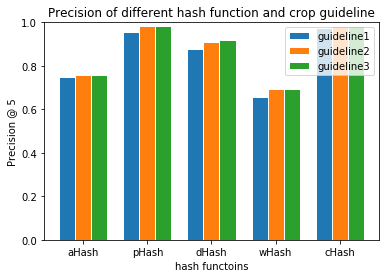

In [32]:
plot(5)

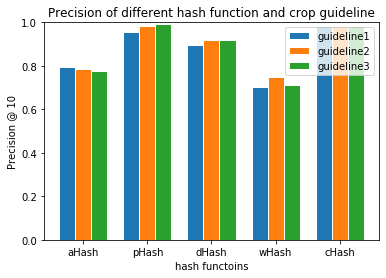

In [33]:
plot(10)

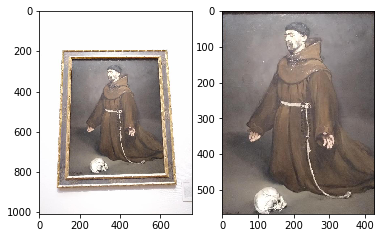

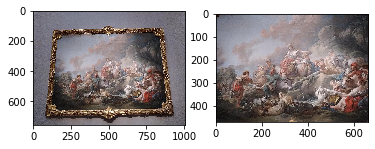

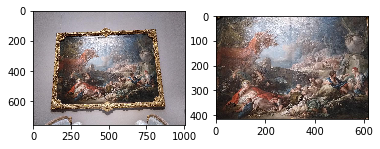

In [34]:
for i in [6, 68, 71]:
    fig = plt.figure()
    #
    name = pic['name'][i]
    crop = pic['l3'][i]
    image_path = PIC_PATH / name
    #
    image = Image.open(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image))
    #
    c_image = image.crop(to_box(image, crop))
    plt.subplot(1, 2, 2)
    plt.imshow(np.array(c_image))
    plt.show()